In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# Lightly adapted from https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb

# Automatically generating object masks with SAM

Since SAM 2 can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image.

The class `SAM2AutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Environment Set-up

If running locally using jupyter, first install `SAM 2` in your environment using the installation instructions in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [1]:
using_colab = True

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/cars.jpg

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-v1x4y3cm
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-v1x4y3cm
  Resolved https://github.com/facebookresearch/sam2.git to commit c2ec8e14a185632b0a5d8b161928ceb50197eddc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.6 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=SAM_2-1.0-cp310-cp

## Set-up

In [29]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image


In [4]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [167]:
import shutil
import time
import cv2

def compress_folder_to_zip(folder_path, zip_path):
    shutil.make_archive(zip_path, 'zip', folder_path)

def get_timestamp():
    return int(time.time())

np.random.seed(3)

def show_anns(image_name, anns, width, height, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    # ax = plt.gca()
    # ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    # img[:, :, 3] = 0
    i = 0
    !rm -rf images/mask_images images/segment_images ./*.zip
    for ann in sorted_anns:
        m = ann['segmentation']
        # color_mask = np.concatenate([np.random.random(3), [0.5]])
        color_mask = np.concatenate([[1,1,1], [1]])
        img[:, :, 3] = 0
        img[m] = color_mask
        # print(img)
        if borders:
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (1, 1, 1, 1), thickness=1)

        plt.figure(figsize=(width, height) , facecolor=(0,0,0,1))
        plt.axis('off')
        plt.imshow(img, cmap='gray')

        output_folder = f'images/mask_images/{image_name}'
        # 如果输出文件夹不存在，则创建
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        plt.savefig(f'images/mask_images/{image_name}/pic-{i+1}.jpg')
        plt.show()
        i += 1

## Example image

## Automatic mask generation

To run automatic mask generation, provide a version of SAM 2 to the `SAM2AutomaticMaskGenerator` class. Set the path below to the SAM 2 checkpoint.

In [5]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

# mask_generator = SAM2AutomaticMaskGenerator(sam2)

/usr/local/lib/python3.10/dist-packages/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


To generate masks, just run `generate` on an image.

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

Show all the masks overlayed on the image.

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [168]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=16,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)

In [158]:
image_name = 'zjq'
image_path = f'./images/{image_name}.jpg'
image = Image.open(image_path)
image = np.array(image.convert("RGB"))
# 获取图片尺寸
width, height = image.shape[1], image.shape[0]
width = width / 100
height = height / 100
print(width, height, f'images/{image_name}.jpg')

6.4 6.4 images/zjq.jpg


In [169]:
masks2 = mask_generator_2.generate(image)

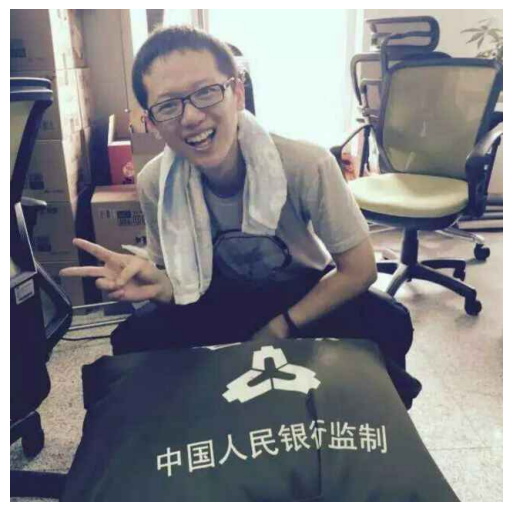

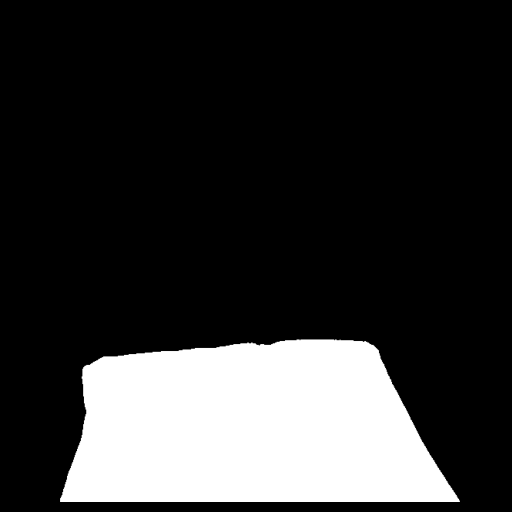

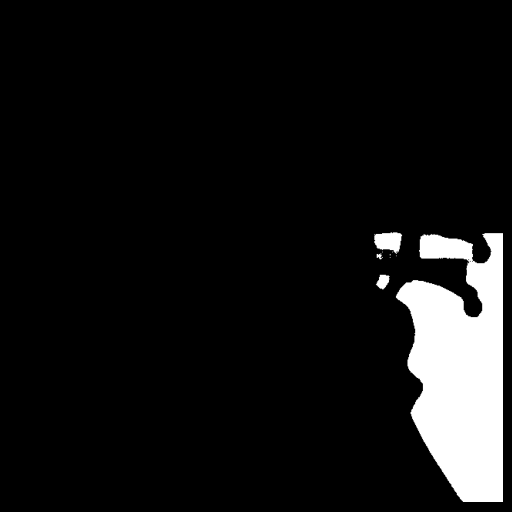

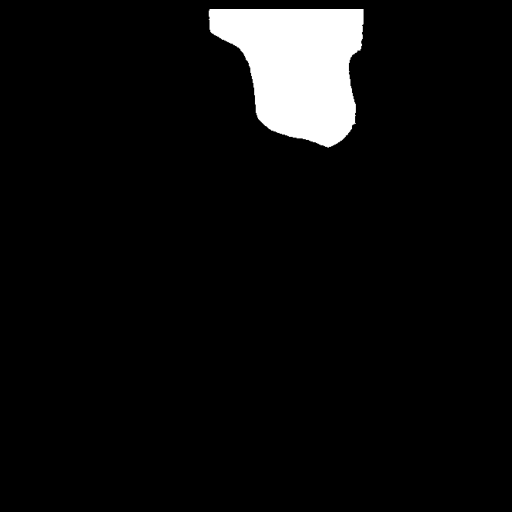

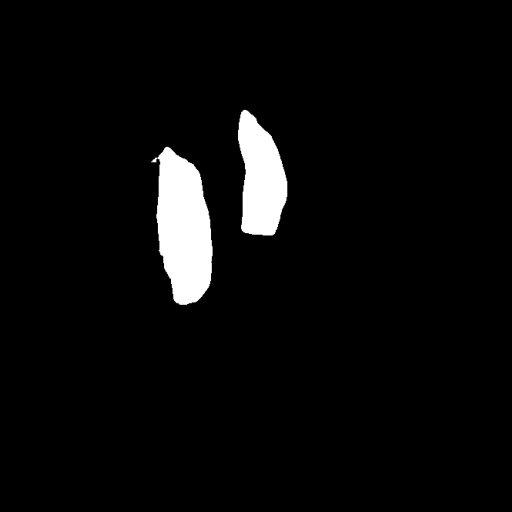

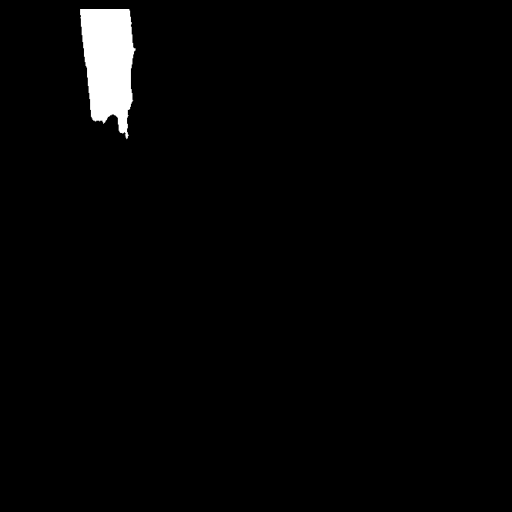

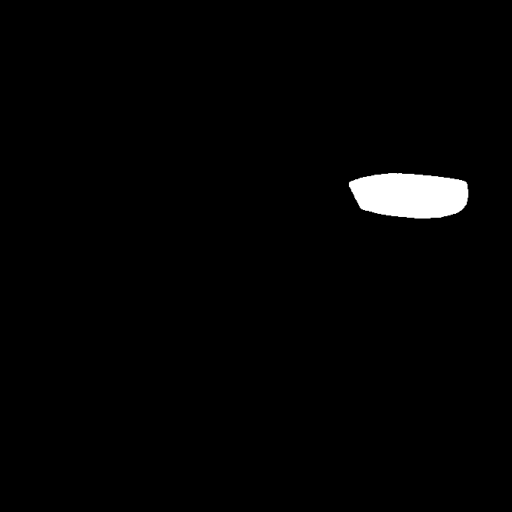

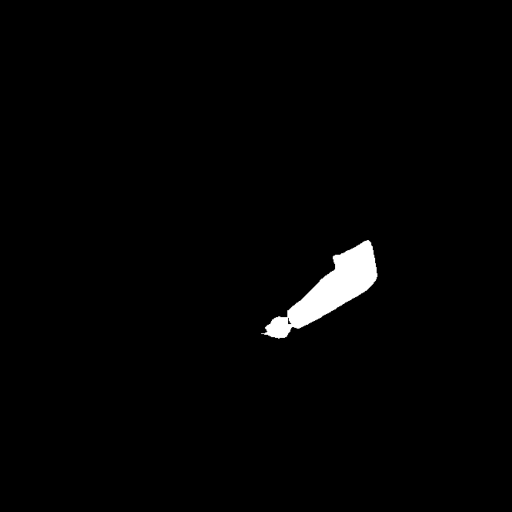

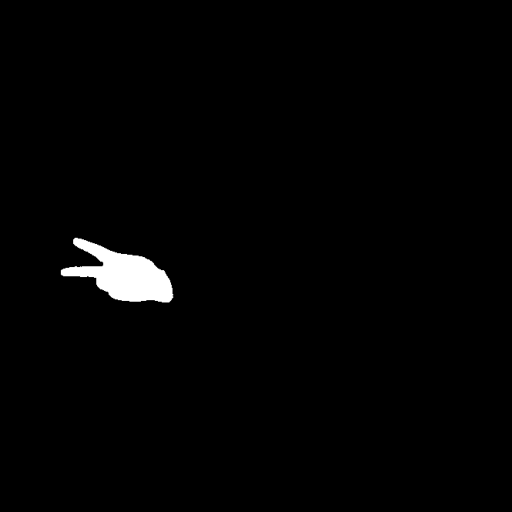

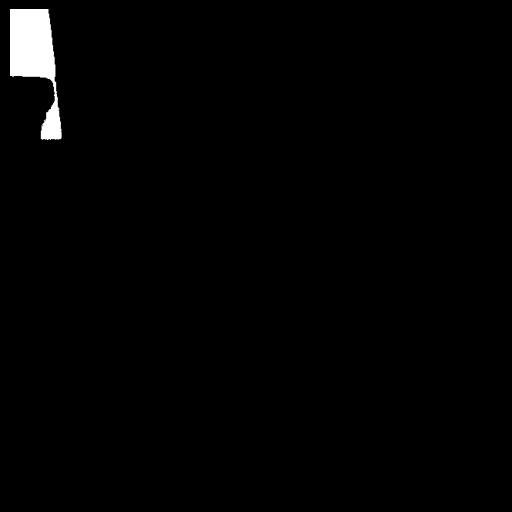

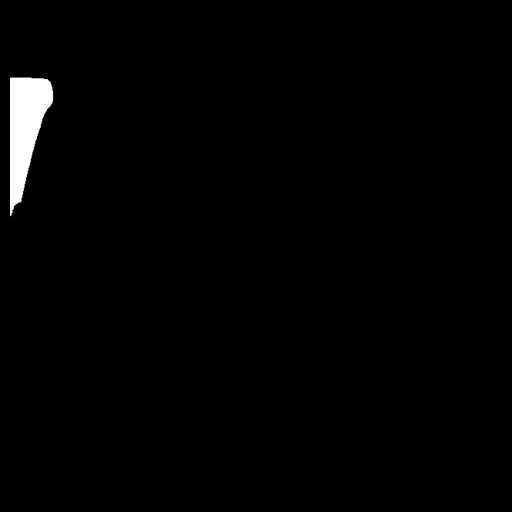

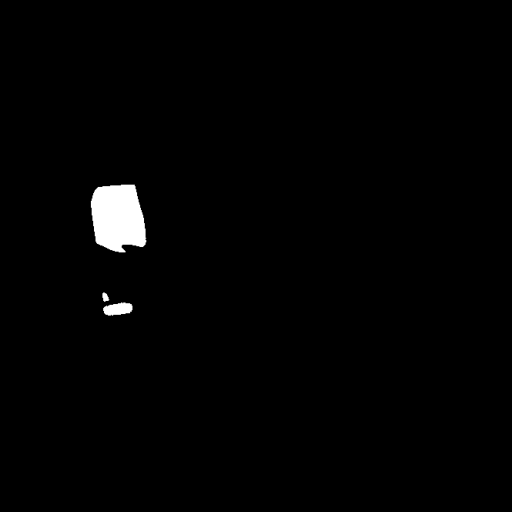

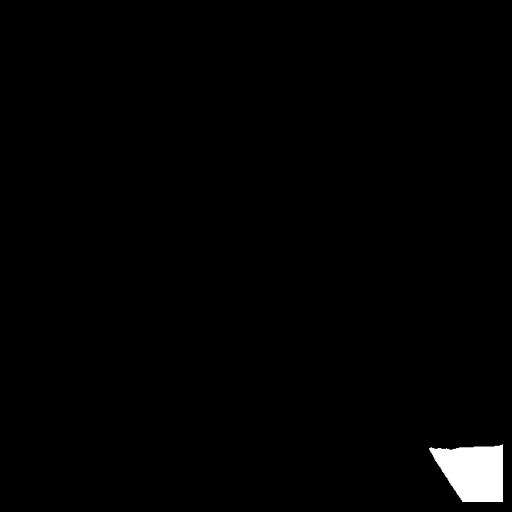

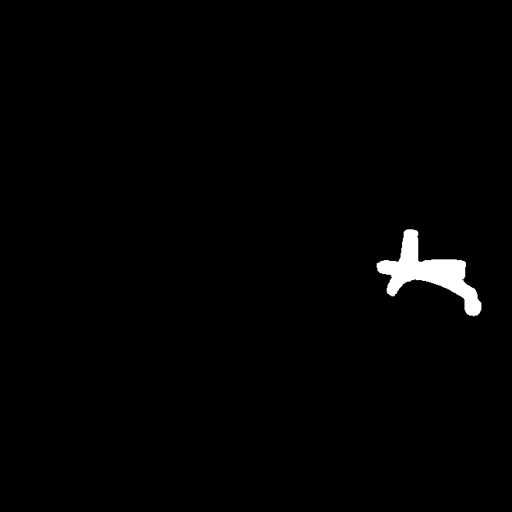

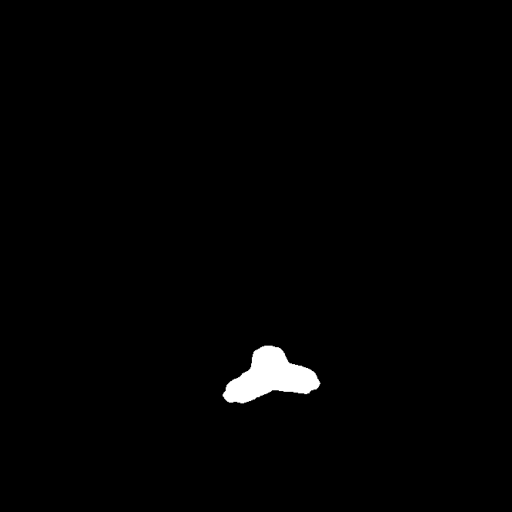

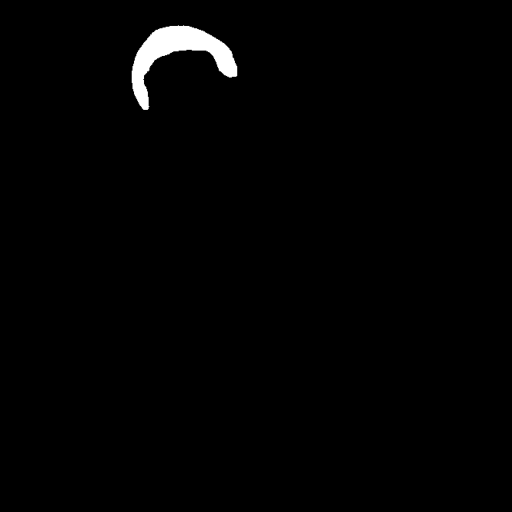

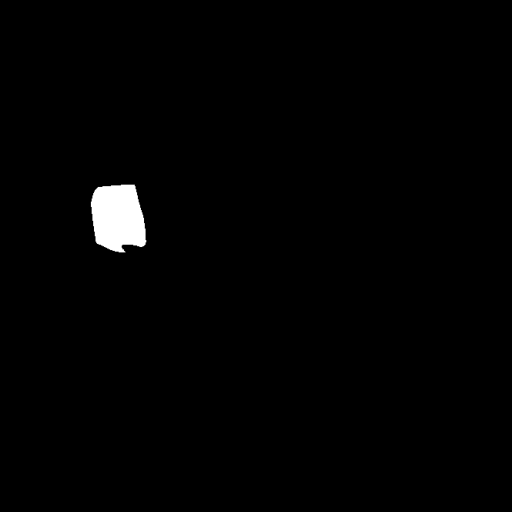

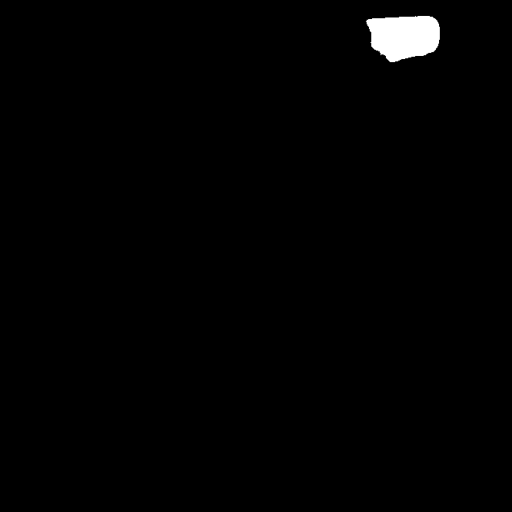

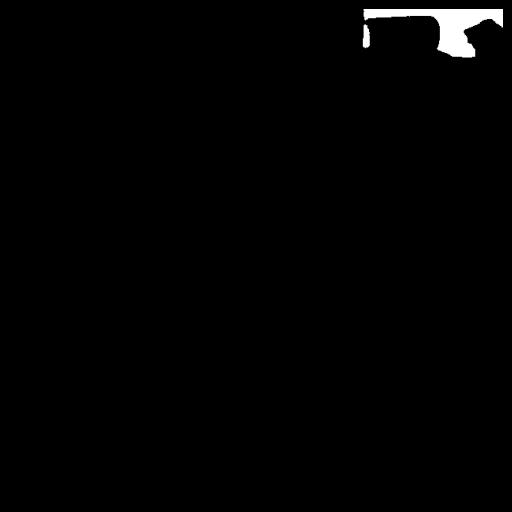

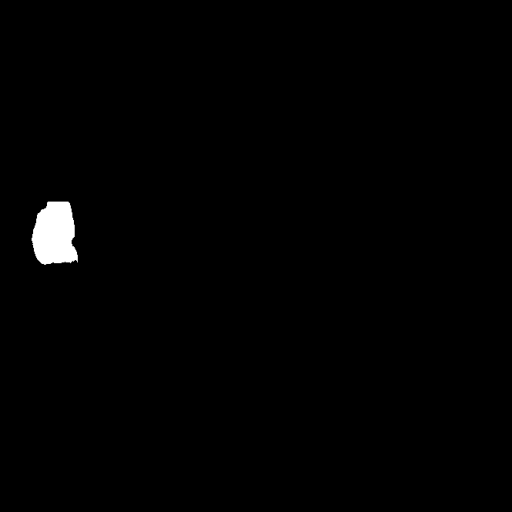

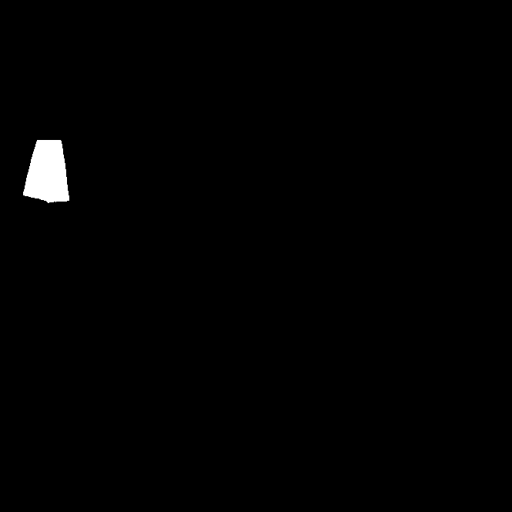

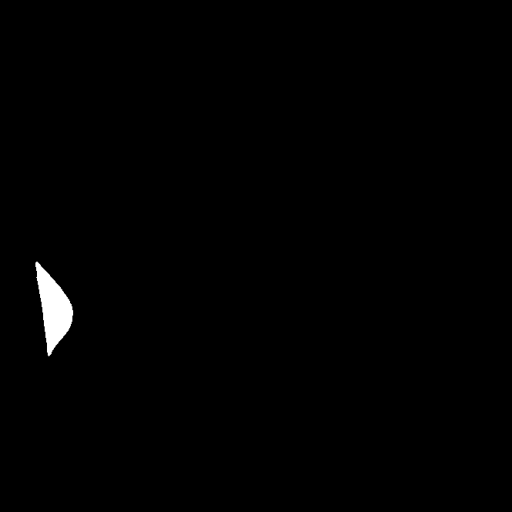

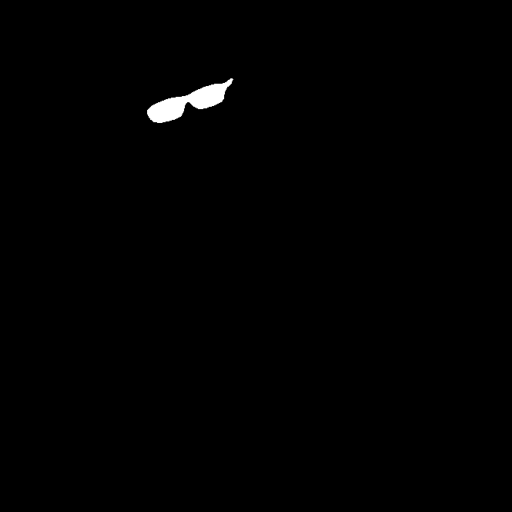

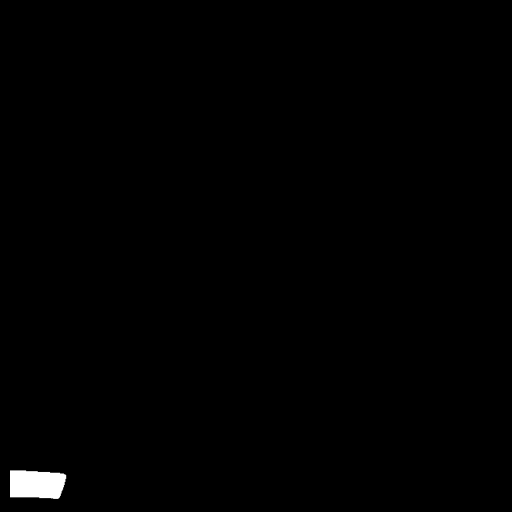

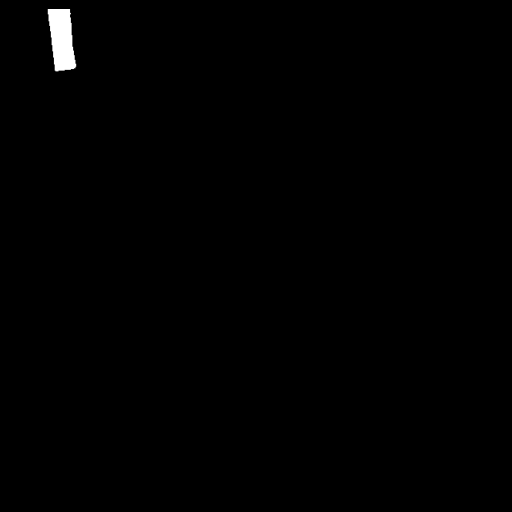

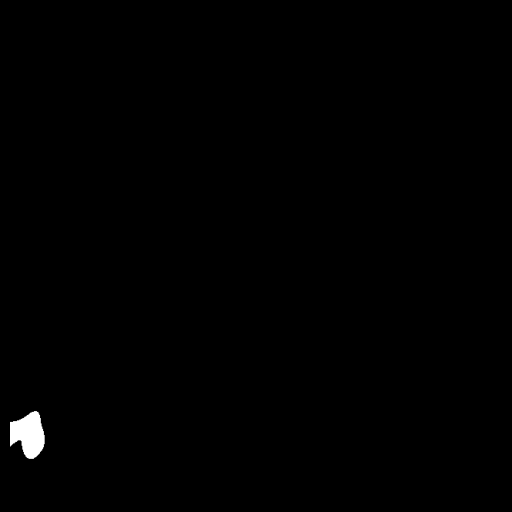

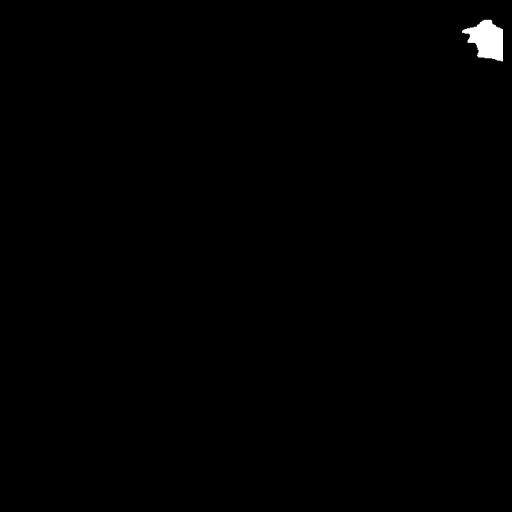

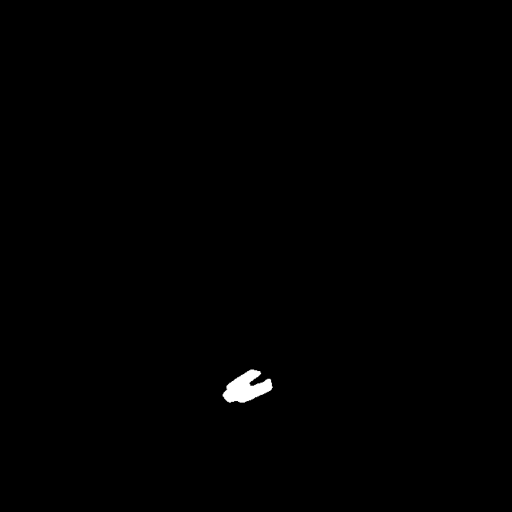

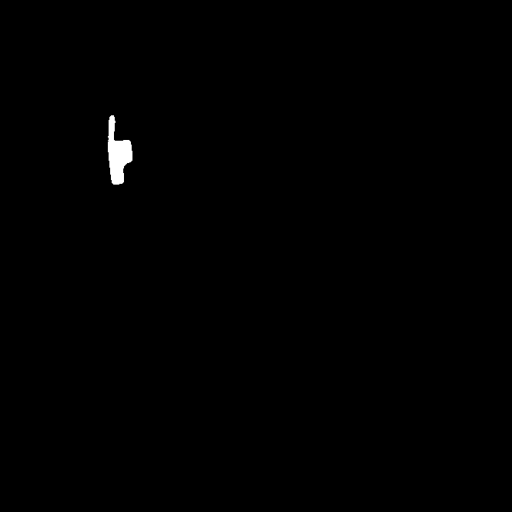

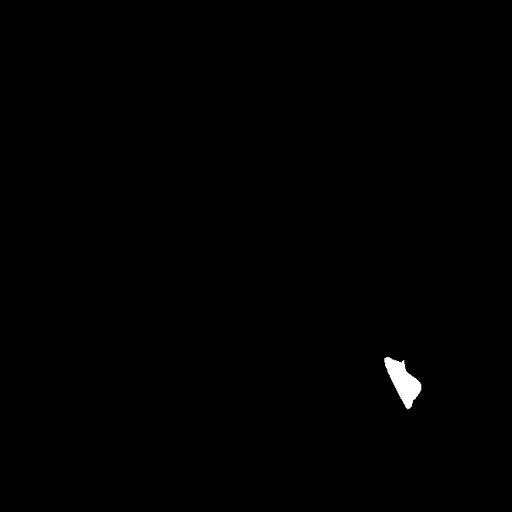

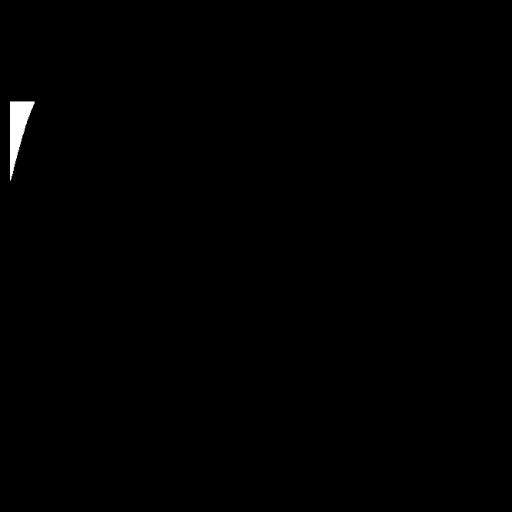

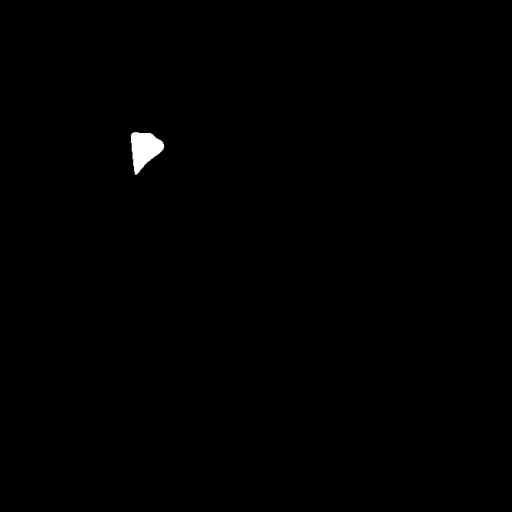

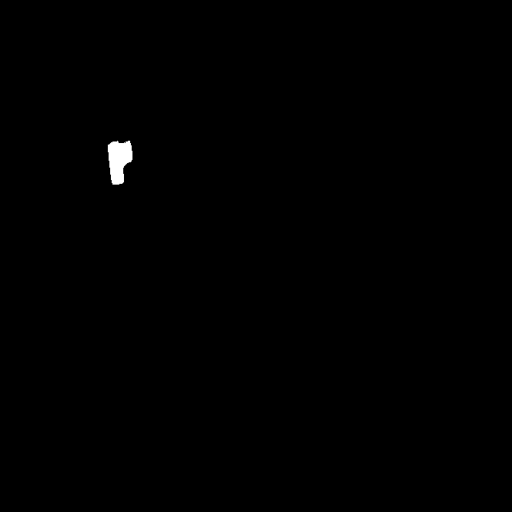

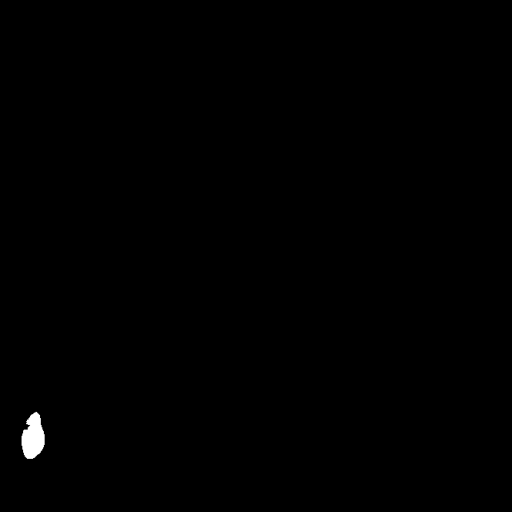

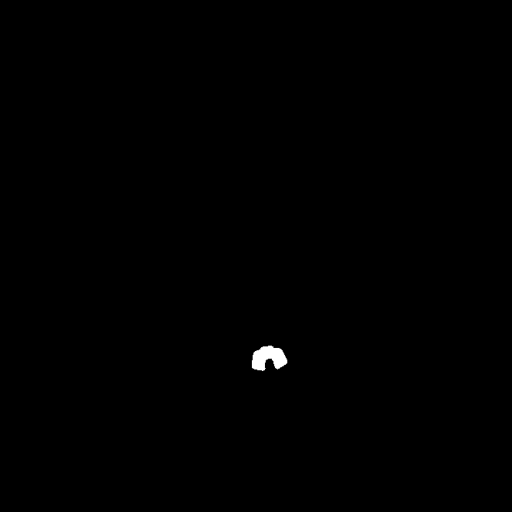

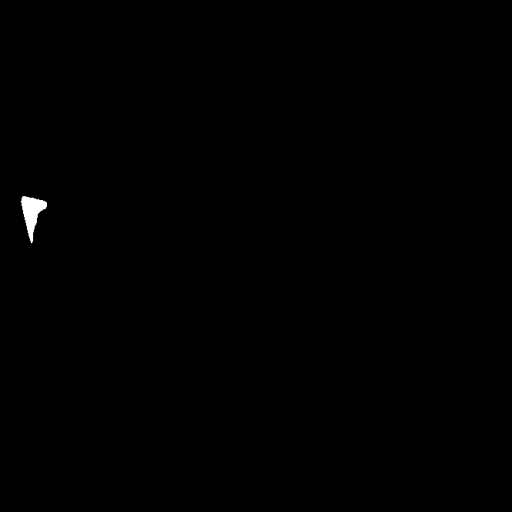

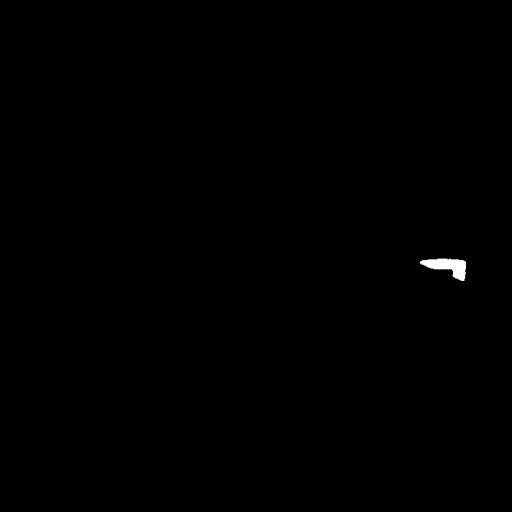

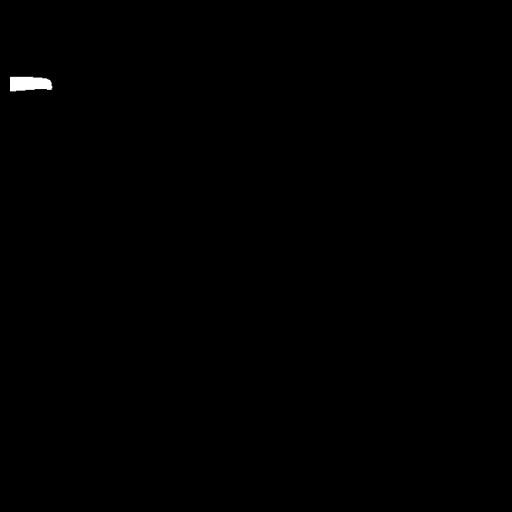

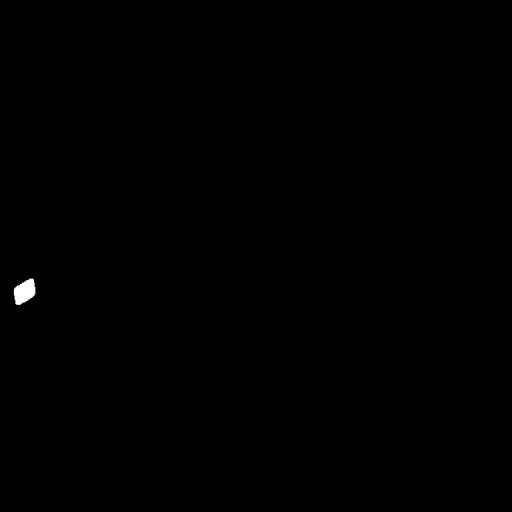

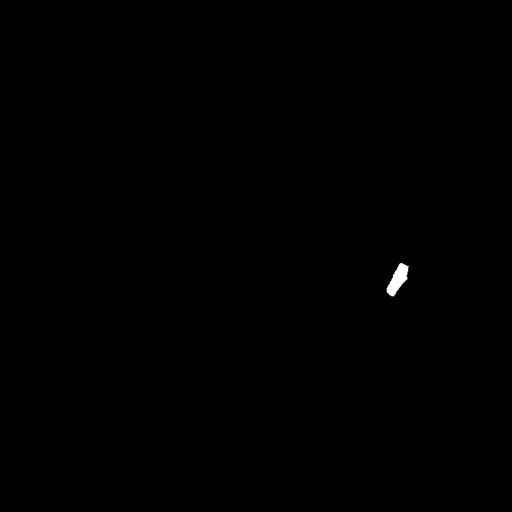

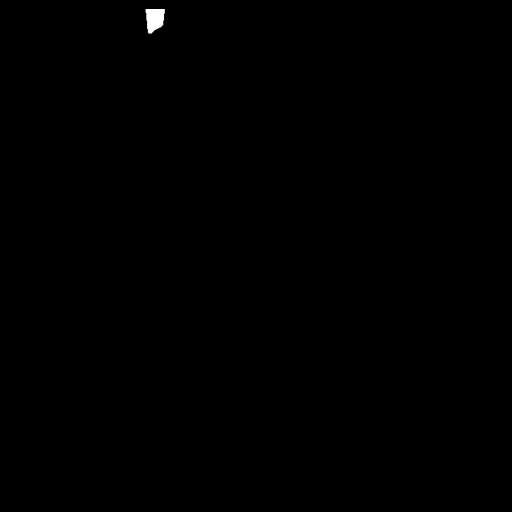

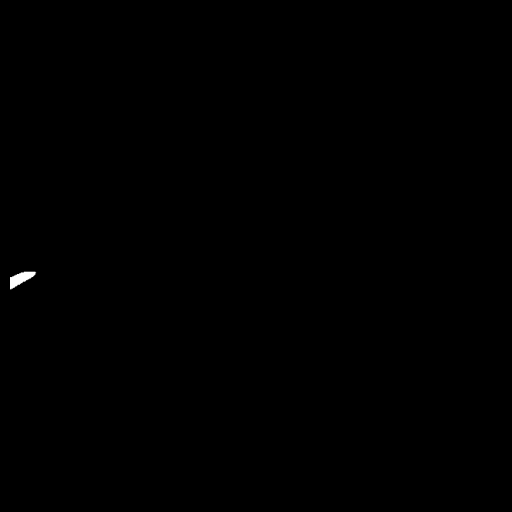

In [170]:
plt.figure(figsize=(width, height))
plt.axis('off')
plt.imshow(image)
show_anns(image_name, masks2, width, height)

pic-25.jpg
pic-35.jpg
pic-33.jpg
pic-26.jpg
pic-2.jpg
pic-11.jpg
pic-19.jpg
pic-3.jpg
pic-5.jpg
pic-23.jpg
pic-4.jpg
pic-30.jpg
pic-24.jpg
pic-36.jpg
pic-17.jpg
pic-12.jpg
pic-15.jpg
pic-10.jpg
pic-31.jpg
pic-18.jpg
pic-8.jpg
pic-28.jpg
pic-14.jpg
pic-39.jpg
pic-34.jpg
pic-37.jpg
pic-32.jpg
pic-7.jpg
pic-13.jpg
pic-27.jpg
pic-41.jpg
pic-22.jpg
pic-20.jpg


<ipython-input-171-b4f0515294c7>:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(width, height) , facecolor=(1,1,1,1))


pic-21.jpg
pic-16.jpg
pic-1.jpg
pic-29.jpg
pic-9.jpg
pic-38.jpg
pic-6.jpg
pic-40.jpg


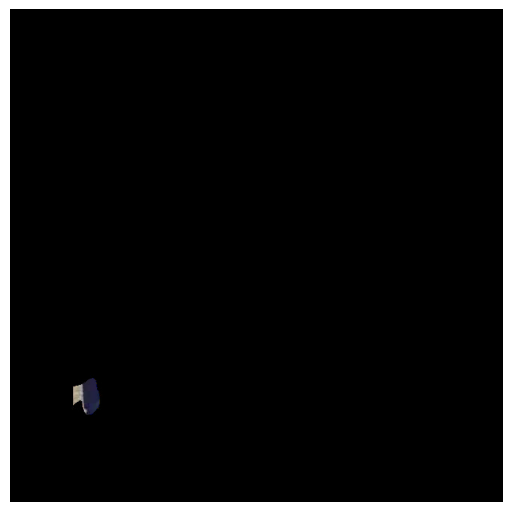

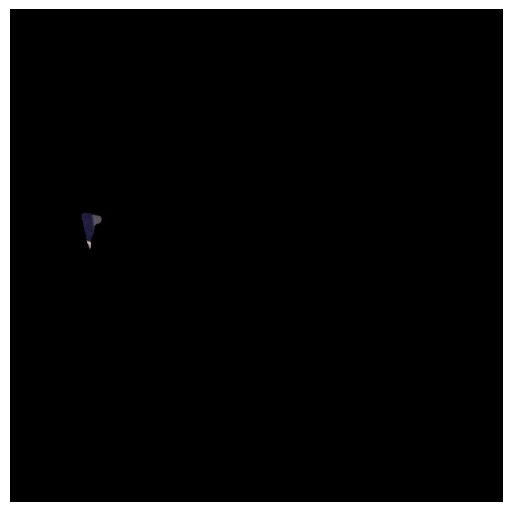

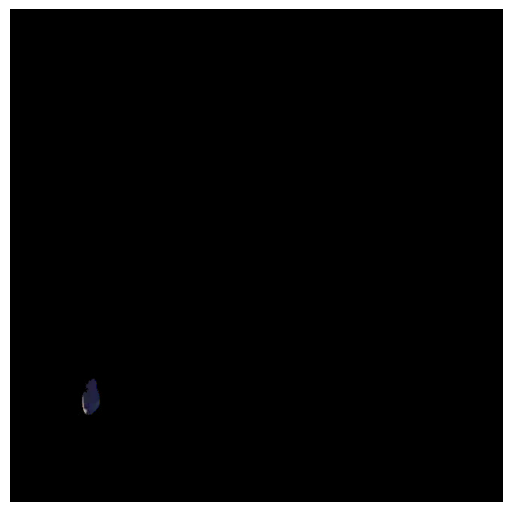

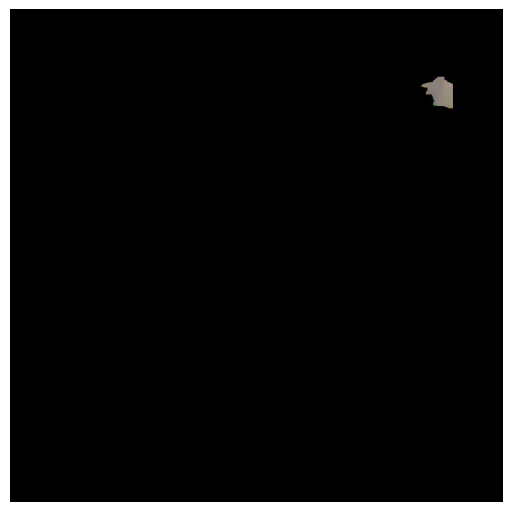

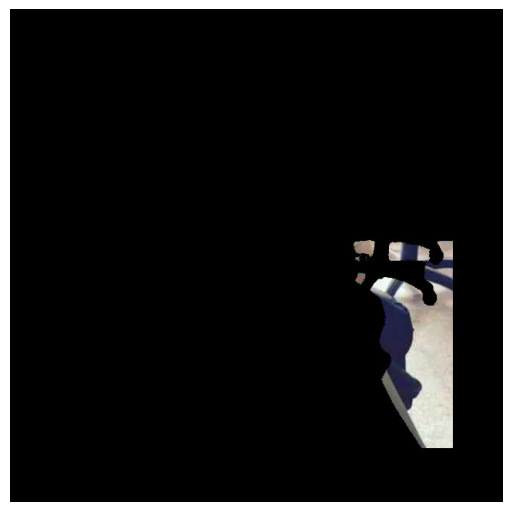

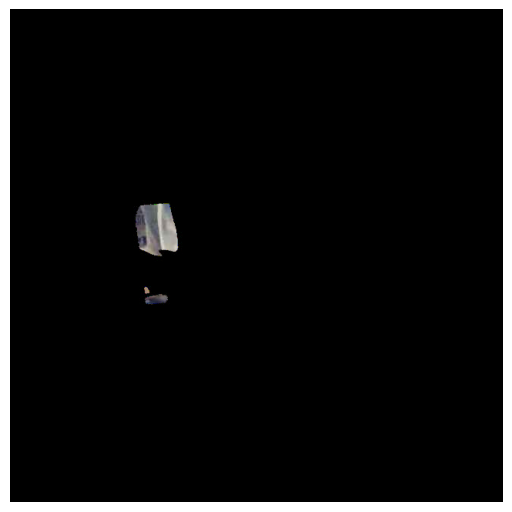

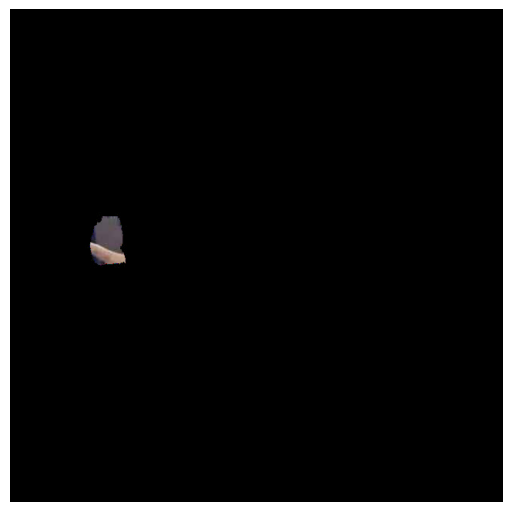

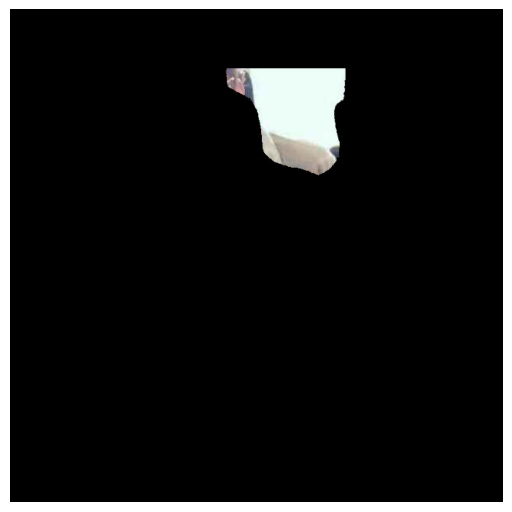

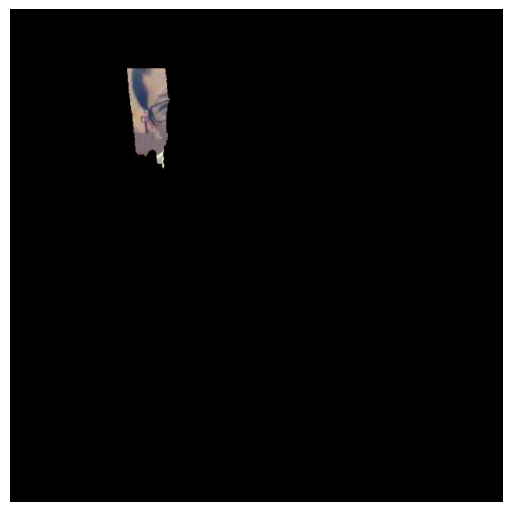

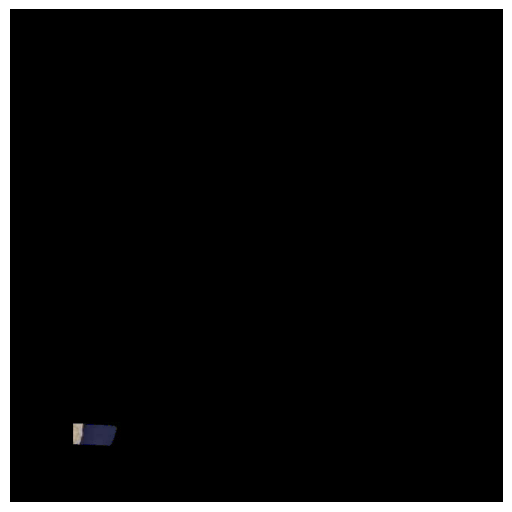

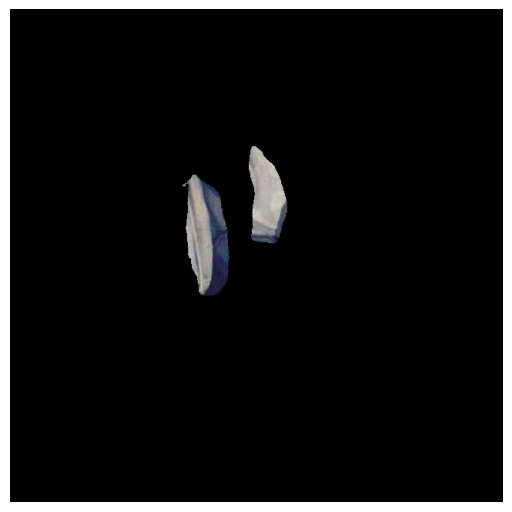

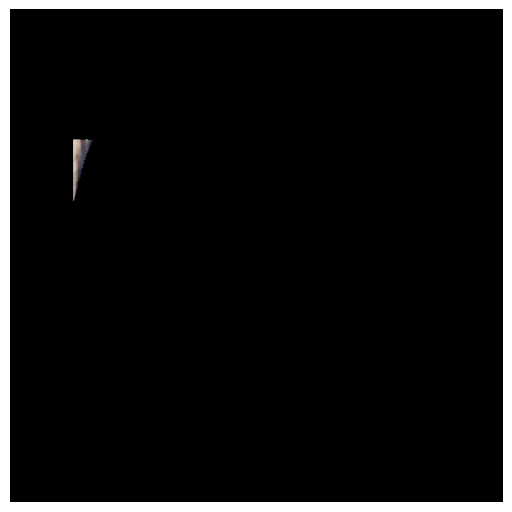

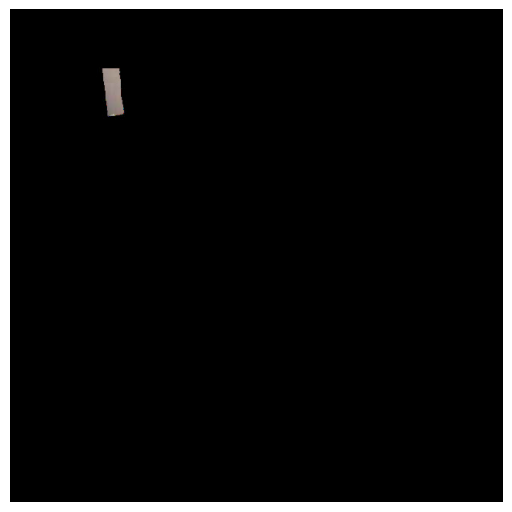

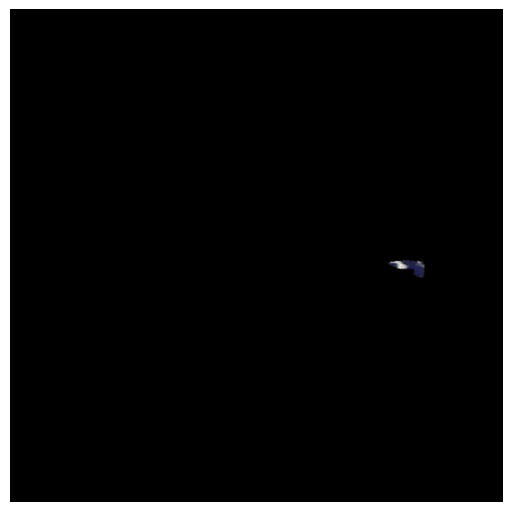

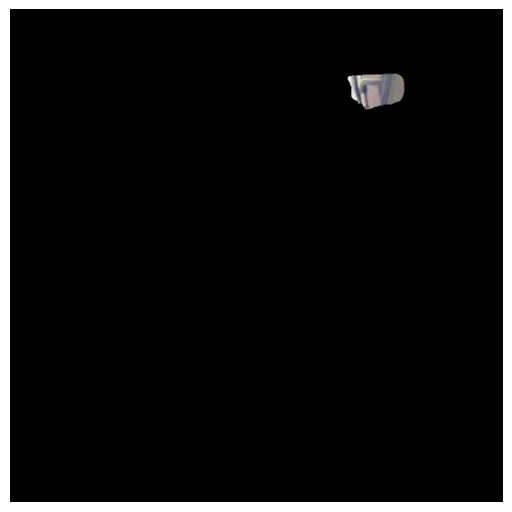

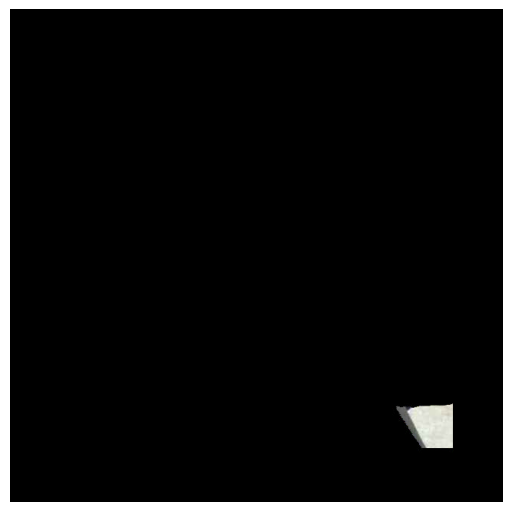

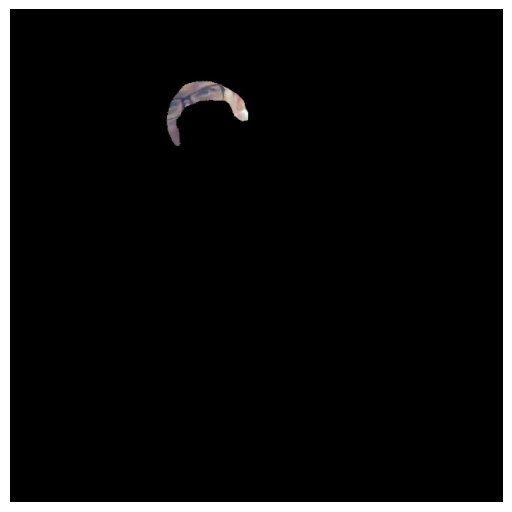

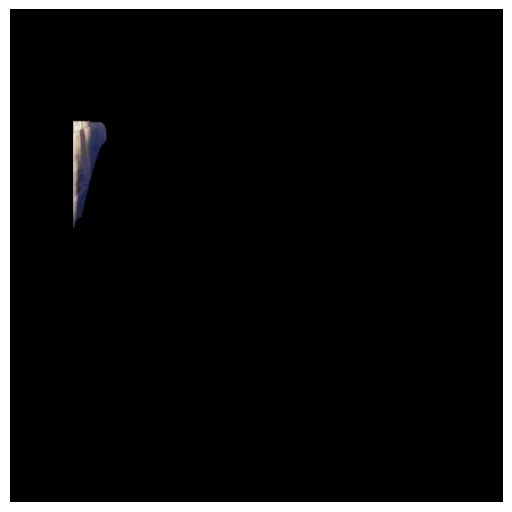

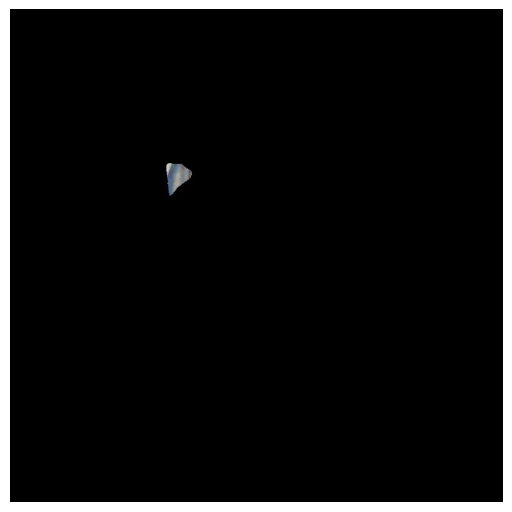

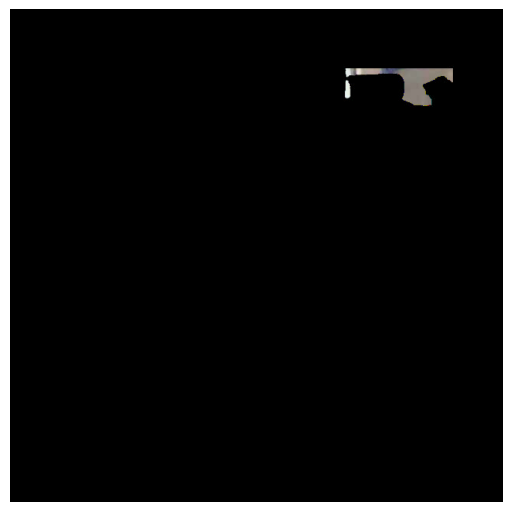

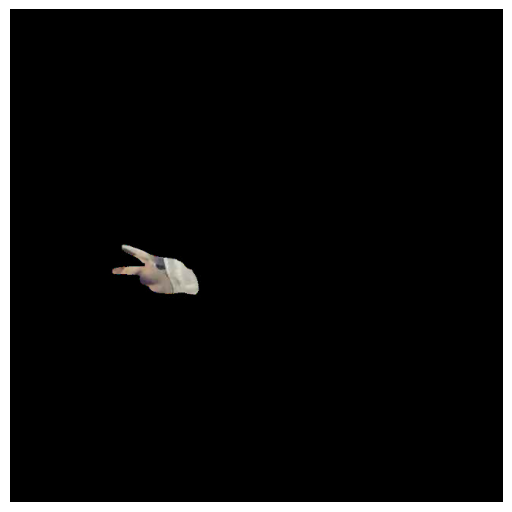

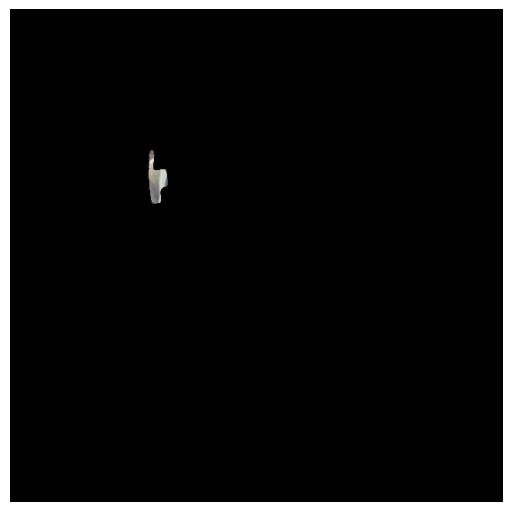

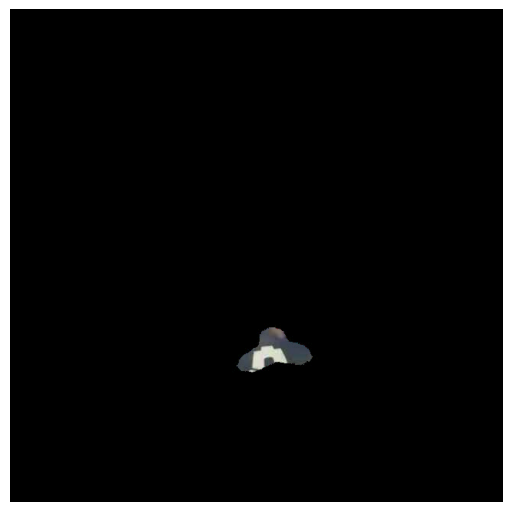

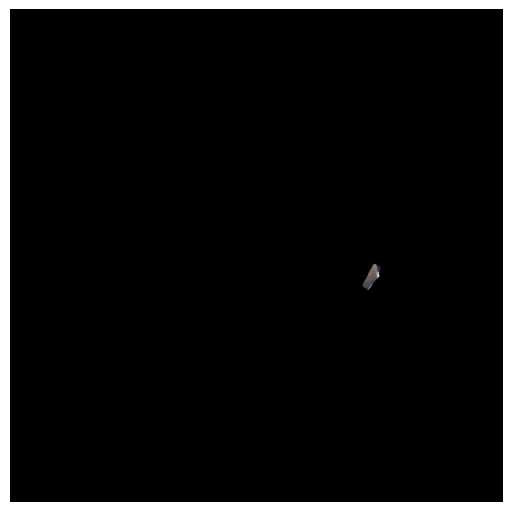

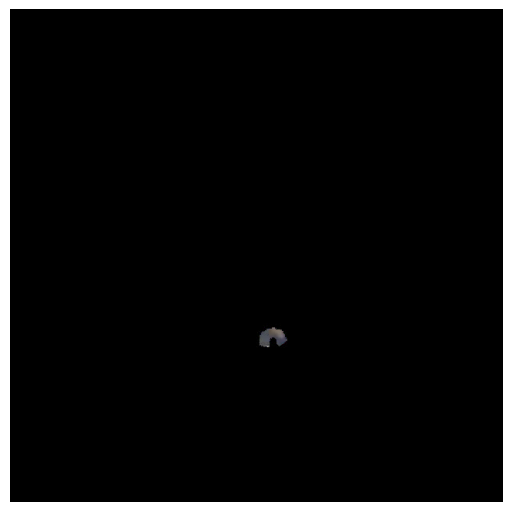

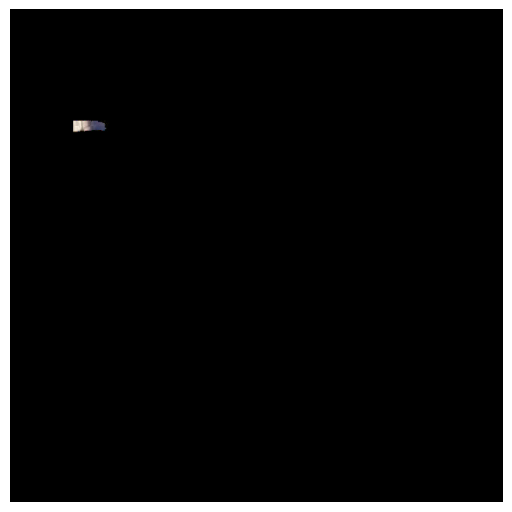

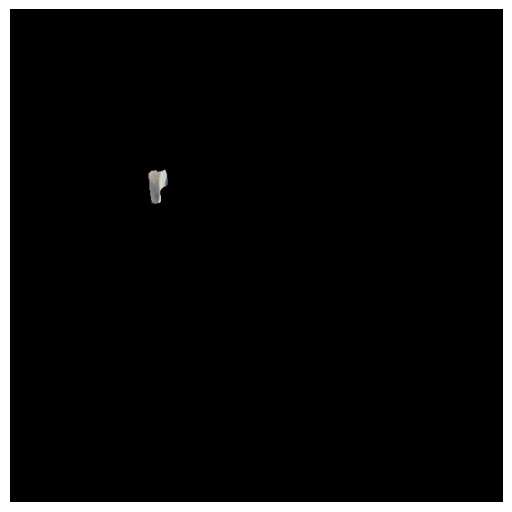

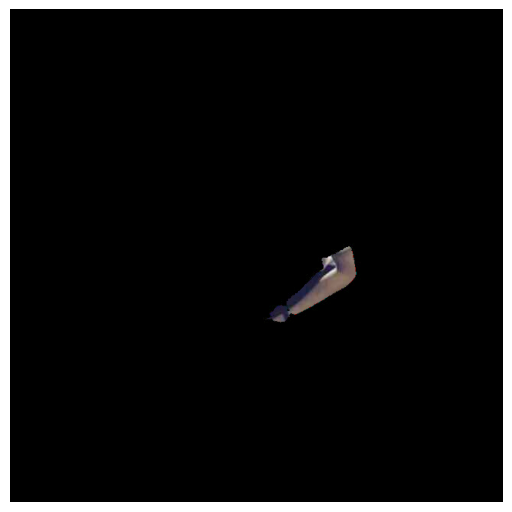

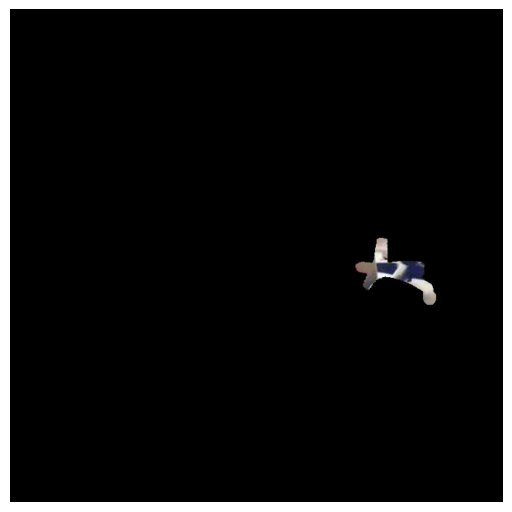

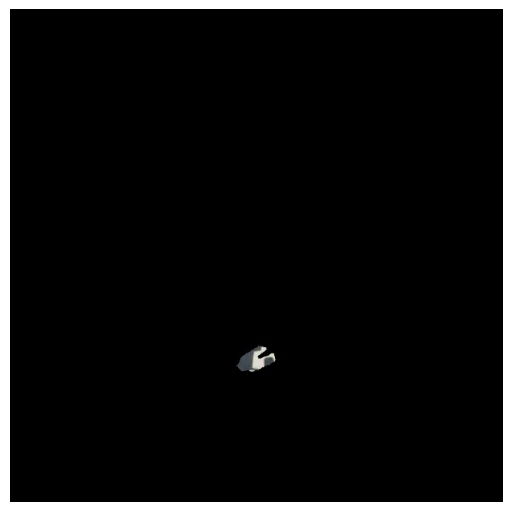

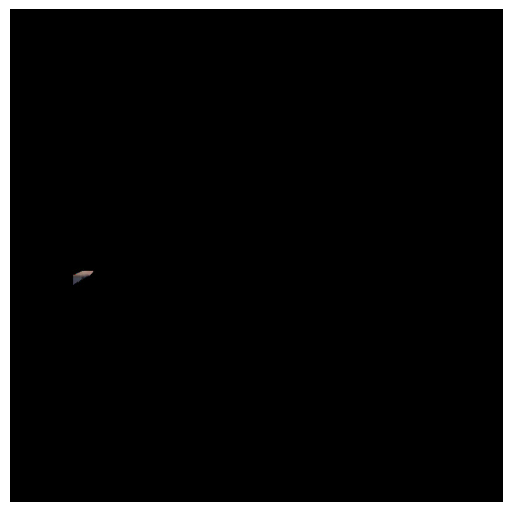

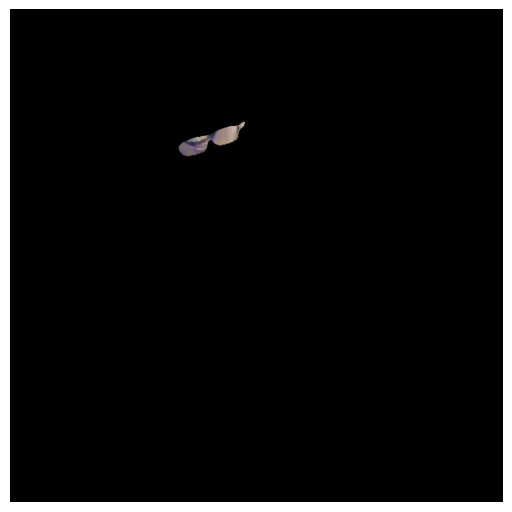

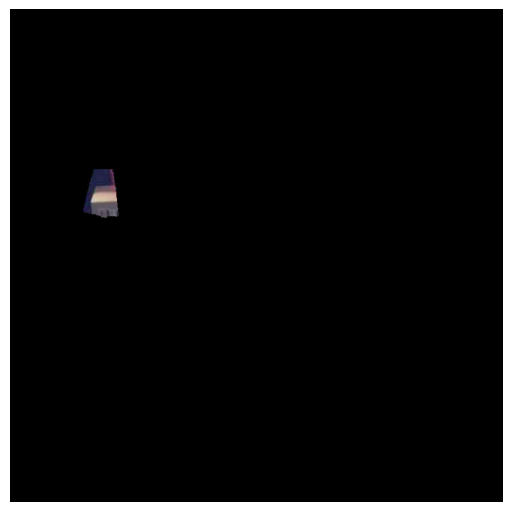

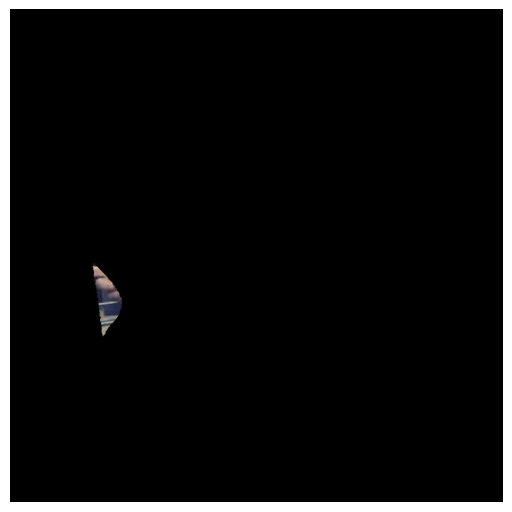

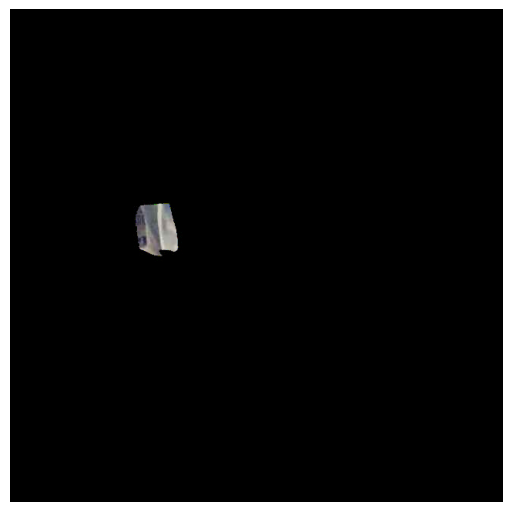

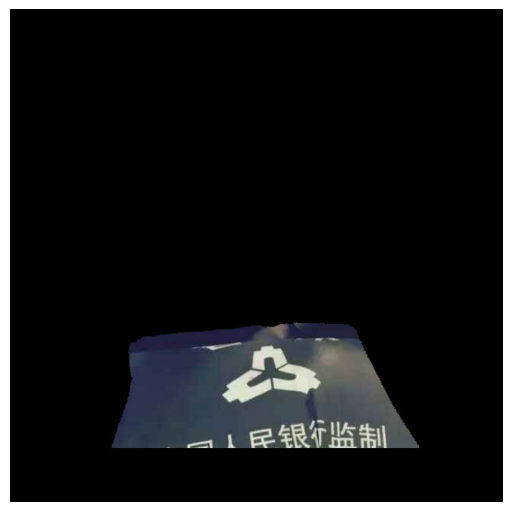

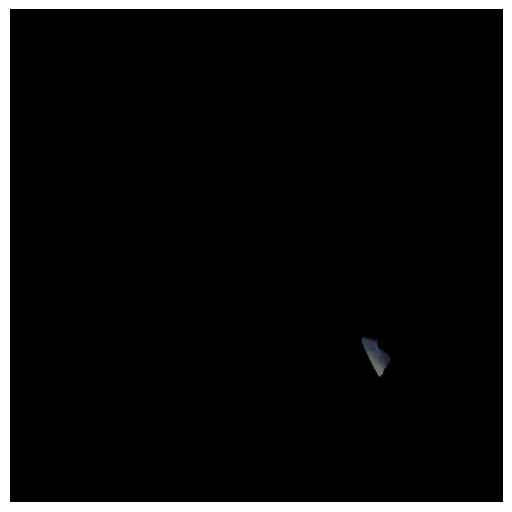

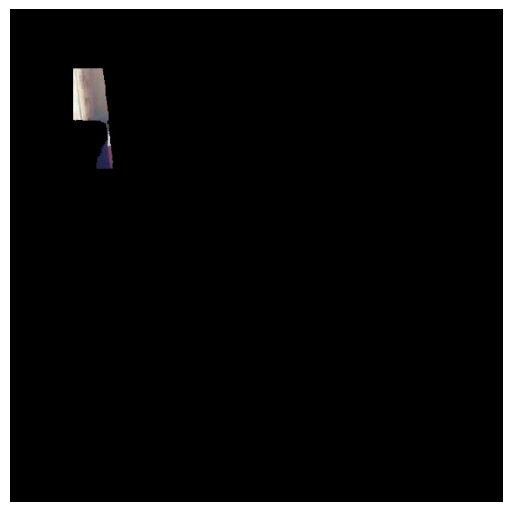

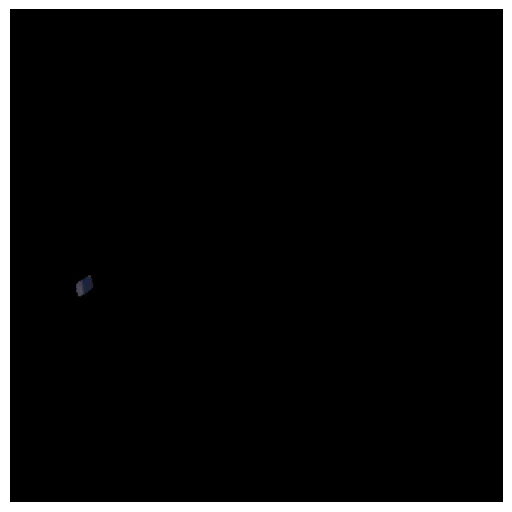

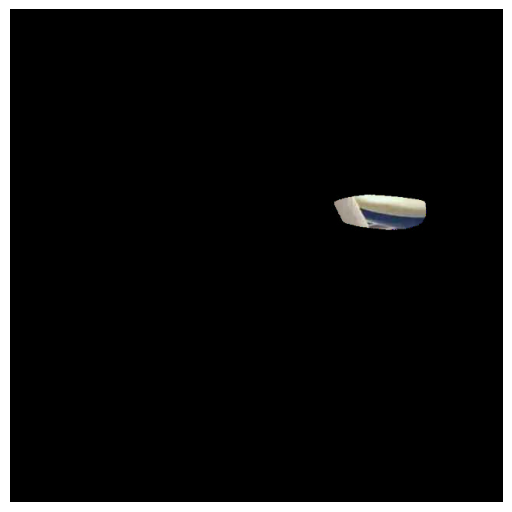

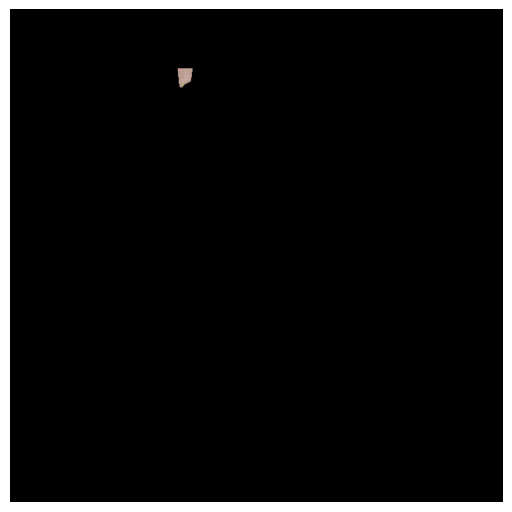

In [171]:
# 根据蒙版切割图片
def segment_image(image_name, mask_path, index):
    image_path = f'./images/{image_name}.jpg'
    save_name = f'seg-{image_name}.jpg'
    # 读取图片和掩码
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
    mask = mask.astype(np.uint8)
    res = cv2.bitwise_and(image, mask)
    # res[res == 0] = 255
    res =  cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
    width, height = image.shape[1], image.shape[0]
    width = width / 100
    height = height / 100
    plt.figure(figsize=(width, height) , facecolor=(1,1,1,1))
    plt.axis('off')
    plt.imshow(res)
    output_folder = f'images/segment_images/{image_name}'
    # 如果输出文件夹不存在，则创建
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    plt.savefig(f'images/segment_images/{image_name}/pic-{index}.jpg')

# 读取函数，用来读取文件夹中的所有函数，输入参数是文件名
def read_directory(image_name):
    mask_directory_name = f'./images/mask_images/{image_name}'
    original_image_path = f'./images/{image_name}.jpg'
    i = 0
    for filename in os.listdir(mask_directory_name):
        print(filename)
        mask_path = mask_directory_name + "/" + filename
        i += 1
        segment_image(image_name, mask_path, i)

read_directory(image_name)

compress_folder_to_zip('images/segment_images', 'temp_segment_'+str(get_timestamp()))

In [150]:
mask_directory_name = './images'
for index in os.listdir(mask_directory_name):
  print(index)

mask_images
cars.jpg


In [126]:
# 读取原图和掩码图片
image_info= plt.imread('images/cars.jpg')
image = cv2.imread('images/cars.jpg')
print(image_info.shape)
# mask = cv2.imread('images/mask_images/pic-1.jpg', cv2.IMREAD_GRAYSCALE)  # 掩码图片应该是灰度图
# plt.imshow(image)
# plt.imshow(mask)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# # 二值化掩码
# _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

# # mask = ~mask
# # mask = mask + 255
# mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
# mask = mask.astype(np.uint8)
# res = cv2.bitwise_and(image, mask)
# # res[res == 0] = 255
# res =  cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
# plt.imshow(res)



(1500, 2250, 3)
